# ¿qué datos son? ¿cómo están relacionados los nodos? ¿cuántos son? ¿cuántas aristas tienen?


Son los personajes de Star Wars: Episode II - Attack of the Clones, conectados si comparten escenas; las aristas tienen pesos igual a la cantidad de escenas que comparten.

In [1]:
from typing import List, Tuple
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BLUES = plt.cm.rainbow

In [2]:
folder = Path("data/dataverse/gexf")
movie_id = 774
fp = folder / f"{movie_id}.gexf"

G = nx.read_gexf(fp, node_type=int)
print("loaded", movie_id, "| Nodos:", G.number_of_nodes(),
      "| Aristas:", G.number_of_edges())

loaded 774 | Nodos: 47 | Aristas: 148


In [3]:
def relabel_nodes_from_attr(
    G: nx.Graph,
    *,
    attr: str = "label",
    fallback_to_id: bool = True,
    make_unique: bool = True,
    copy: bool = True,
) -> nx.Graph:
    """
    Renombra nodos usando G.nodes[n][attr] (p.ej. 'label').
    - make_unique=True agrega sufijos ' (#2)' si hay nombres repetidos.
    """
    base_names = {}
    for n, d in G.nodes(data=True):
        name = d.get(attr)
        if name in (None, "") and fallback_to_id:
            name = str(n)
        base_names[n] = str(name)

    if make_unique:
        counts = {}
        mapping = {}
        for n, nm in base_names.items():
            k = counts.get(nm, 0) + 1
            counts[nm] = k
            mapping[n] = nm if k == 1 else f"{nm} (#{k})"
    else:
        mapping = base_names

    return nx.relabel_nodes(G, mapping, copy=copy)

G = relabel_nodes_from_attr(G, attr="label", make_unique=True, copy=True)

# Realiza tres visualizaciones distintas cambiando opciones como diseño (layout), forma, tamaño o color de nodos, color de aristas, etc.


In [4]:
def _pesos_aristas(G: nx.Graph, weight_attr: str = "weight") -> list[float]:
    # para que podamos usar el minmax de colores
    ws: list[float] = []
    for _, _, d in G.edges(data=True):
        w = d.get(weight_attr, 1.0)
        try:
            ws.append(float(w))
        except Exception:
            ws.append(1.0)
    return ws


def _escala_minmax(values: list[float], a: float, b: float) -> list[float]:
    vmin, vmax = min(values), max(values)
    return [a + (v - vmin) * (b - a) / (vmax - vmin) for v in values]


def visualizacion1(
    G: nx.Graph,
    *,
    seed: int = 0,
    iterations: int = 250,
    figsize=(14, 10),
    font_size: int = 8,
    nombre_pelicula: str | None = None,
):
    pos = nx.spring_layout(G, seed=seed, iterations=iterations)

    fuerza = dict(G.degree(weight="weight"))  # grado ponderado (strength)
    fuerza_vals = [float(fuerza.get(u, 0.0)) for u in G.nodes()]
    node_sizes = [120 + 25 * float(fuerza.get(u, 0.0)) for u in G.nodes()]

    ws = _pesos_aristas(G, weight_attr="weight")
    edge_widths = _escala_minmax(ws, 0.6, 4.0)

    titulo = (
        f"{nombre_pelicula}\n"
        "Red de coapariciones a pares de personajes — Layout Spring "
        "Tamaño y color del nodo: grado ponderado "
        "Grosor y color de arista: peso de coaparicion"
    )

    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=ws, edge_cmap=BLUES, alpha=0.45)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=fuerza_vals, cmap=BLUES,
                           linewidths=0.6, edgecolors=None)

    labels = {u: str(u) for u in G.nodes()}  # si ya relabelaste, u es el nombre
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size)

    plt.title(titulo)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualizacion2(
    G: nx.Graph,
    *,
    figsize=(14, 10),
    font_size: int = 8,
    nombre_pelicula: str | None = None,
):
    pos = nx.kamada_kawai_layout(G)

    fuerza = dict(G.degree())
    fuerza_vals = [float(fuerza.get(u, 0.0)) for u in G.nodes()]
    node_sizes = [140 + 10 * float(fuerza.get(u, 0.0)) for u in G.nodes()]

    ws = _pesos_aristas(G)
    edge_widths = _escala_minmax(ws, 0.6, 4.5)

    titulo = (
        f"{nombre_pelicula}\n"
        "Red de coapariciones de personajes — Layout Kamada-Kawai "
        "Tamaño y color del nodo: grado ponderado "
        "Grosor y color de arista: peso de coaparicion"
    )

    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=ws, edge_cmap=BLUES, alpha=0.50)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=fuerza_vals, cmap=BLUES,
                           linewidths=0.6, edgecolors=None)

    labels = {u: str(u) for u in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size)

    plt.title(titulo)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualizacion3(
    G: nx.Graph,
    *,
    figsize=(14, 14),
    font_size: int = 8,
    nombre_pelicula: str | None = None,
):
    pos = nx.circular_layout(G)

    bc = nx.betweenness_centrality(G, normalized=True)
    bc_vals = [bc[u] for u in G.nodes()]
    node_sizes = [180 + 7000 * bc[u] for u in G.nodes()]

    ws = _pesos_aristas(G, weight_attr= "weight")
    edge_widths = _escala_minmax(ws, 0.6, 4.0)

    titulo = (
        f"{nombre_pelicula}\n"
        "Red de coapariciones a pares de personajes — Layout Circular "
        "Tamaño y color del nodo: centralidad de intermediacion "
        "Grosor y color de arista: peso de coaparicion"
    )

    plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=ws, edge_cmap=BLUES, alpha=0.55)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=bc_vals, cmap=BLUES,
                           linewidths=0.6, edgecolors=None)

    labels = {u: str(u) for u in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=font_size)

    plt.title(titulo)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


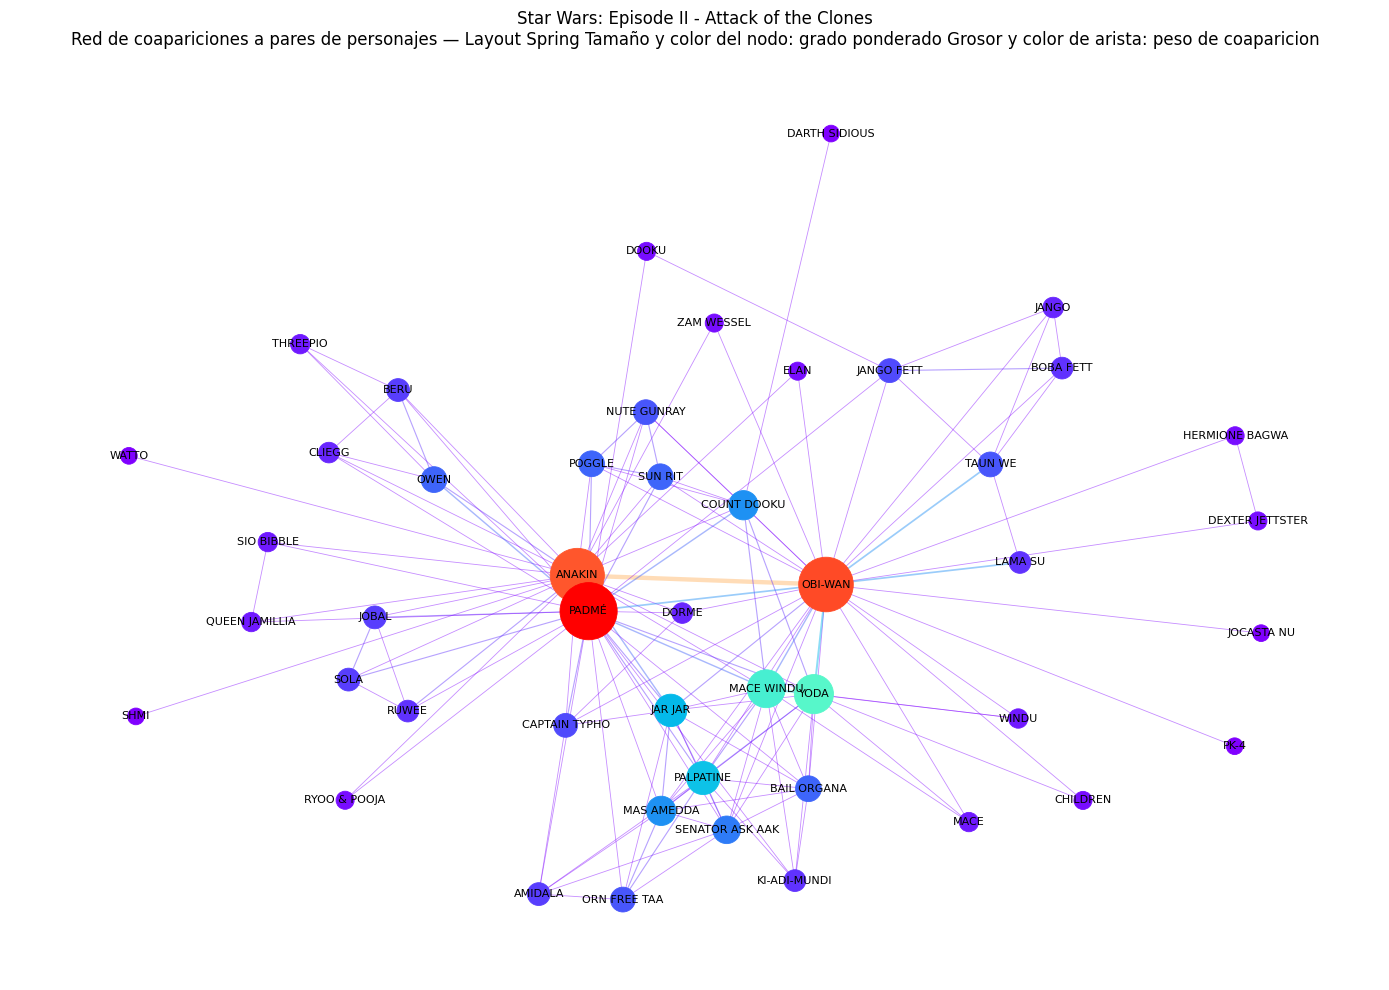

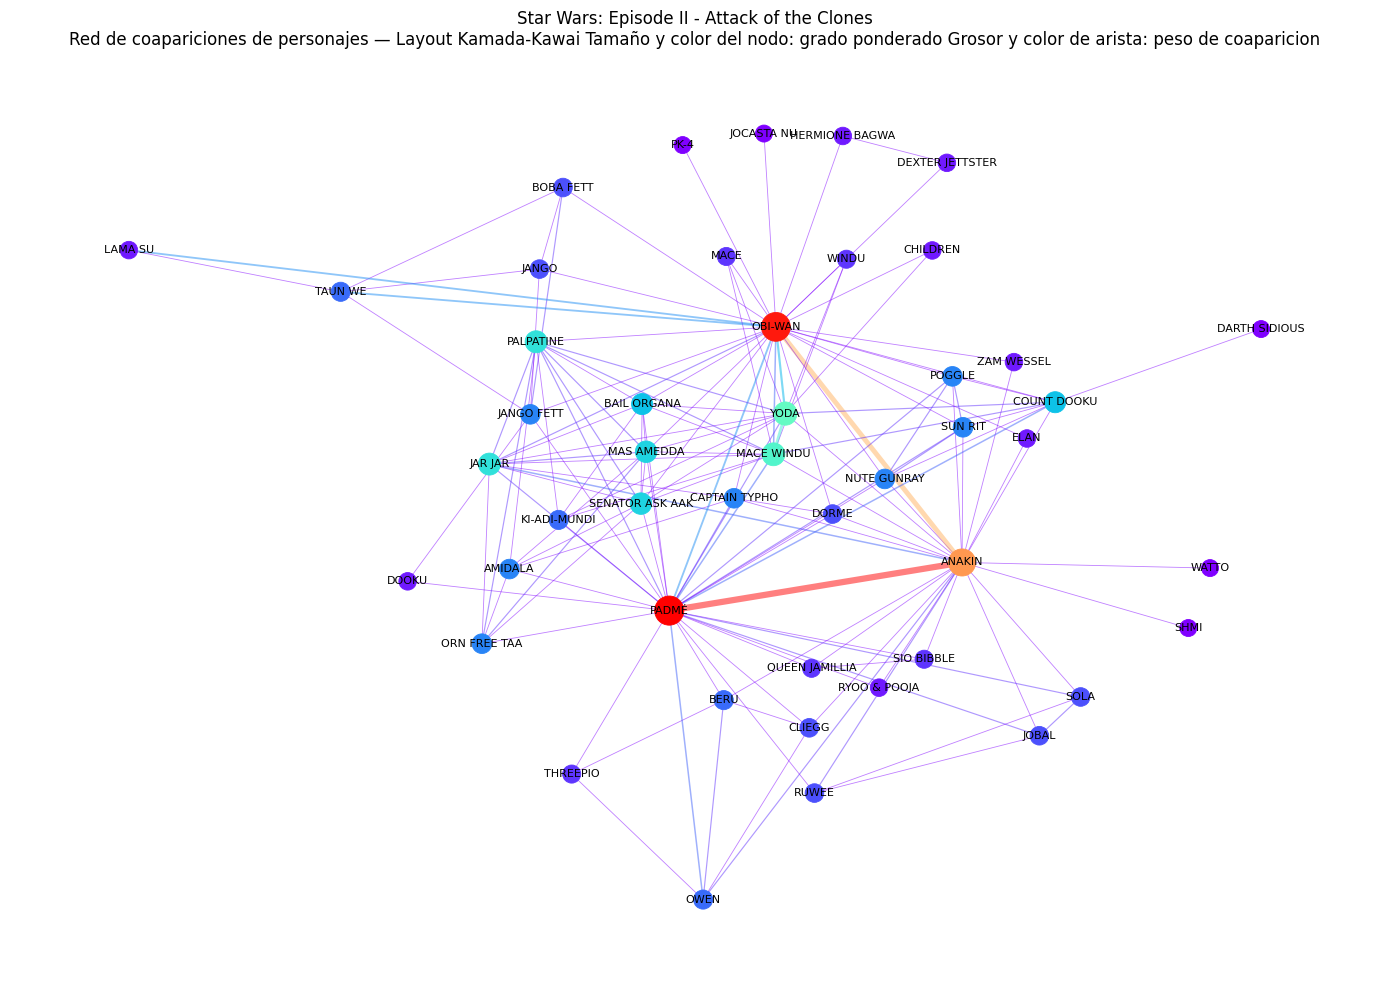

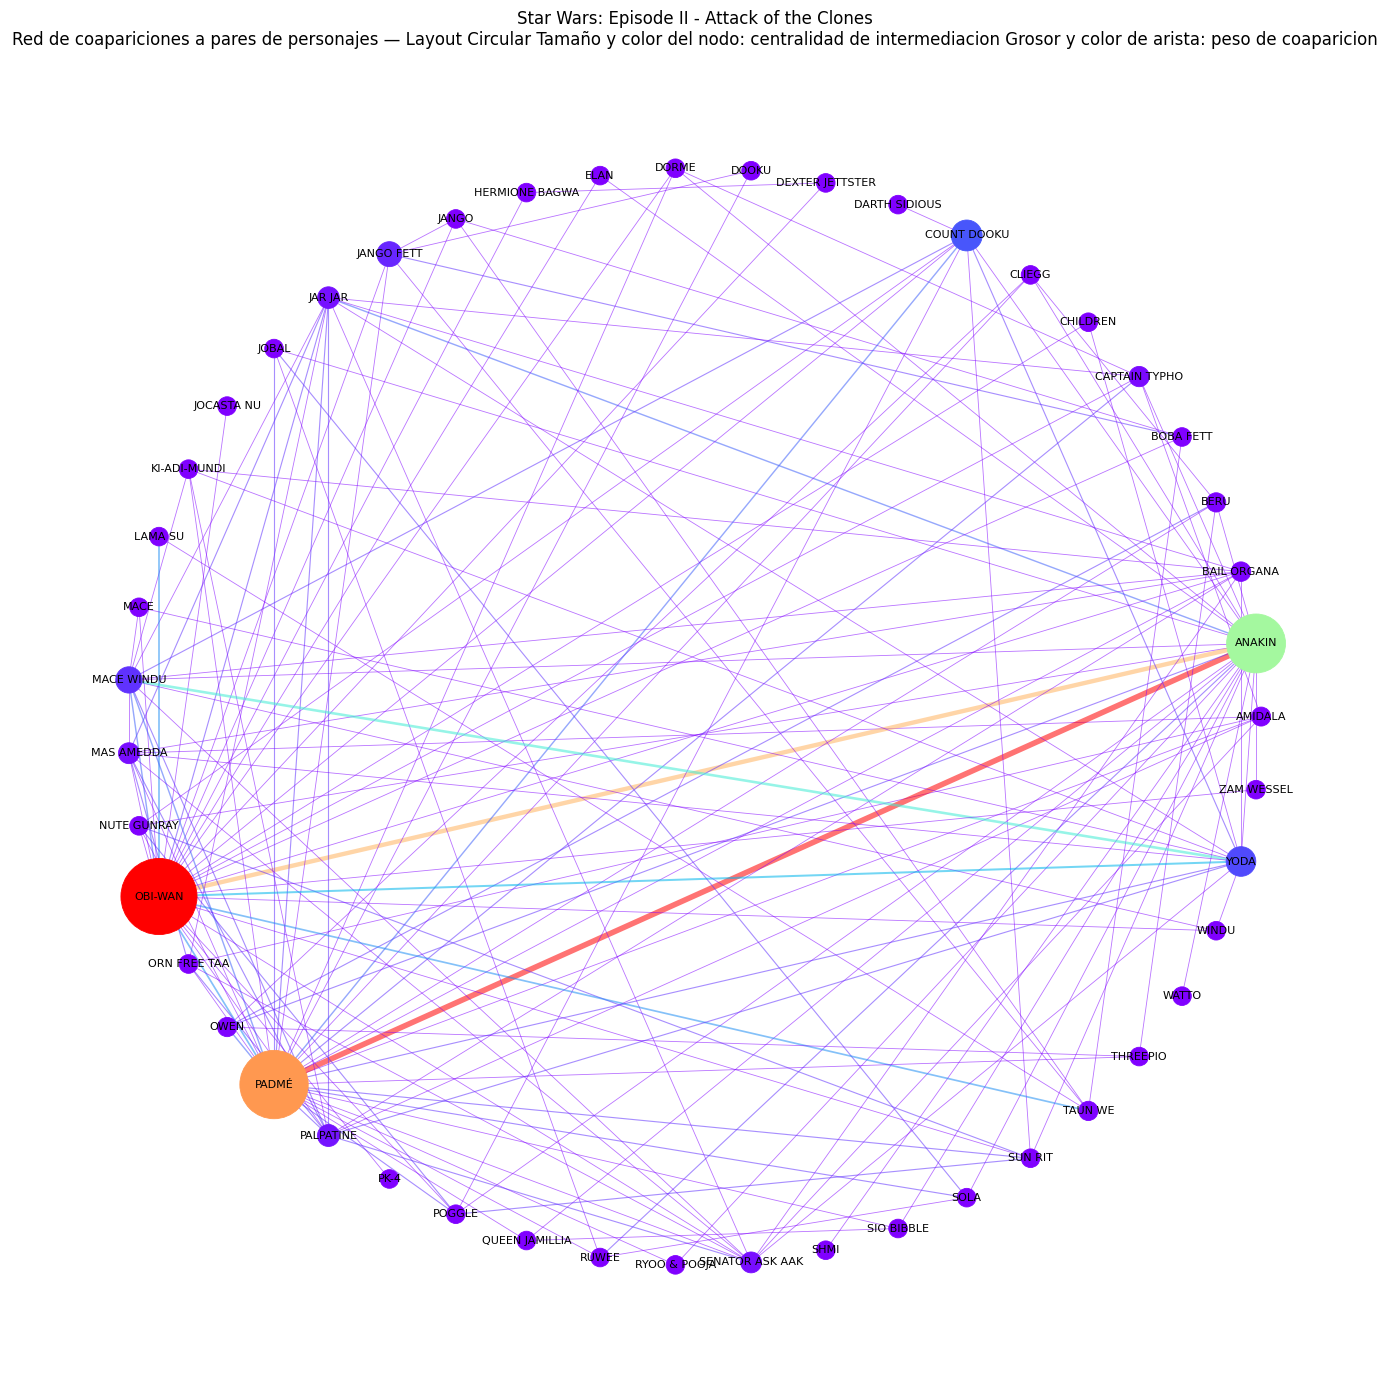

In [5]:
movie_name = "Star Wars: Episode II - Attack of the Clones"

visualizacion1(G, nombre_pelicula=movie_name)
visualizacion2(G, nombre_pelicula=movie_name)
visualizacion3(G, nombre_pelicula=movie_name)


# Genera la matriz de adyacencia de la red.


In [6]:
def adjacency_matrix_df(G: nx.DiGraph, nodelist: List[str] | None = None) -> pd.DataFrame:
    if nodelist is None:
        nodelist = sorted(G.nodes())
    A = nx.to_numpy_array(G, nodelist=nodelist, dtype=int)
    return pd.DataFrame(A, index=nodelist, columns=nodelist)


nodes = sorted(G.nodes())
A_full_df = adjacency_matrix_df(G, nodelist=nodes)

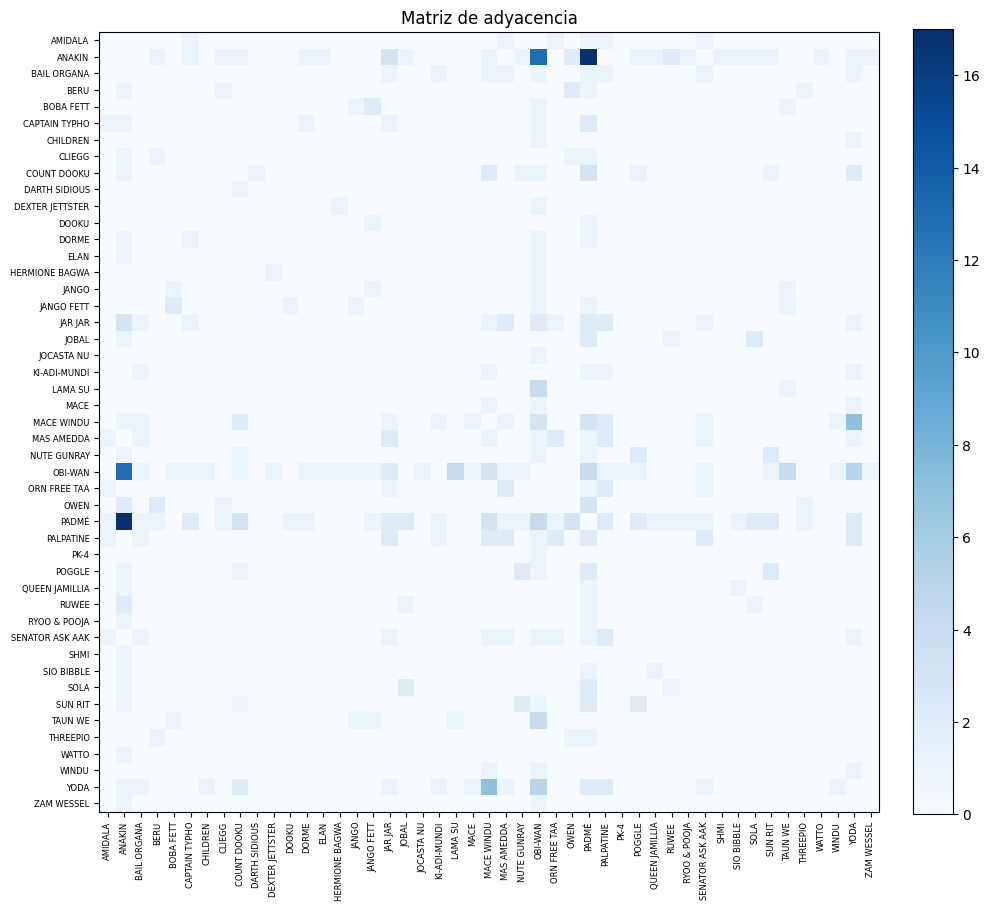

In [7]:
def plot_adjacency_matrix(
    A_df: pd.DataFrame,
    *,
    cmap=plt.cm.Blues,
    figsize=(10, 10),
    tick_fontsize: int = 6,
    title: str | None = "Matriz de adyacencia",
):
    A = A_df.to_numpy()

    plt.figure(figsize=figsize)
    im = plt.imshow(A, cmap=cmap, interpolation="nearest")
    plt.title(title)

    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.xticks(range(len(A_df.columns)), A_df.columns, rotation=90, fontsize=tick_fontsize)
    plt.yticks(range(len(A_df.index)), A_df.index, fontsize=tick_fontsize)

    plt.tight_layout()
    plt.show()


plot_adjacency_matrix(A_full_df)

# Utiliza la función "subgraph" para extraer una subred de 8 nodos y visualizarla.


In [8]:
k = 8
deg = dict(G.degree())  
top_nodes = sorted(deg, key=lambda u: (-deg[u], str(u)))[:k]
G_top8 = G.subgraph(top_nodes).copy()

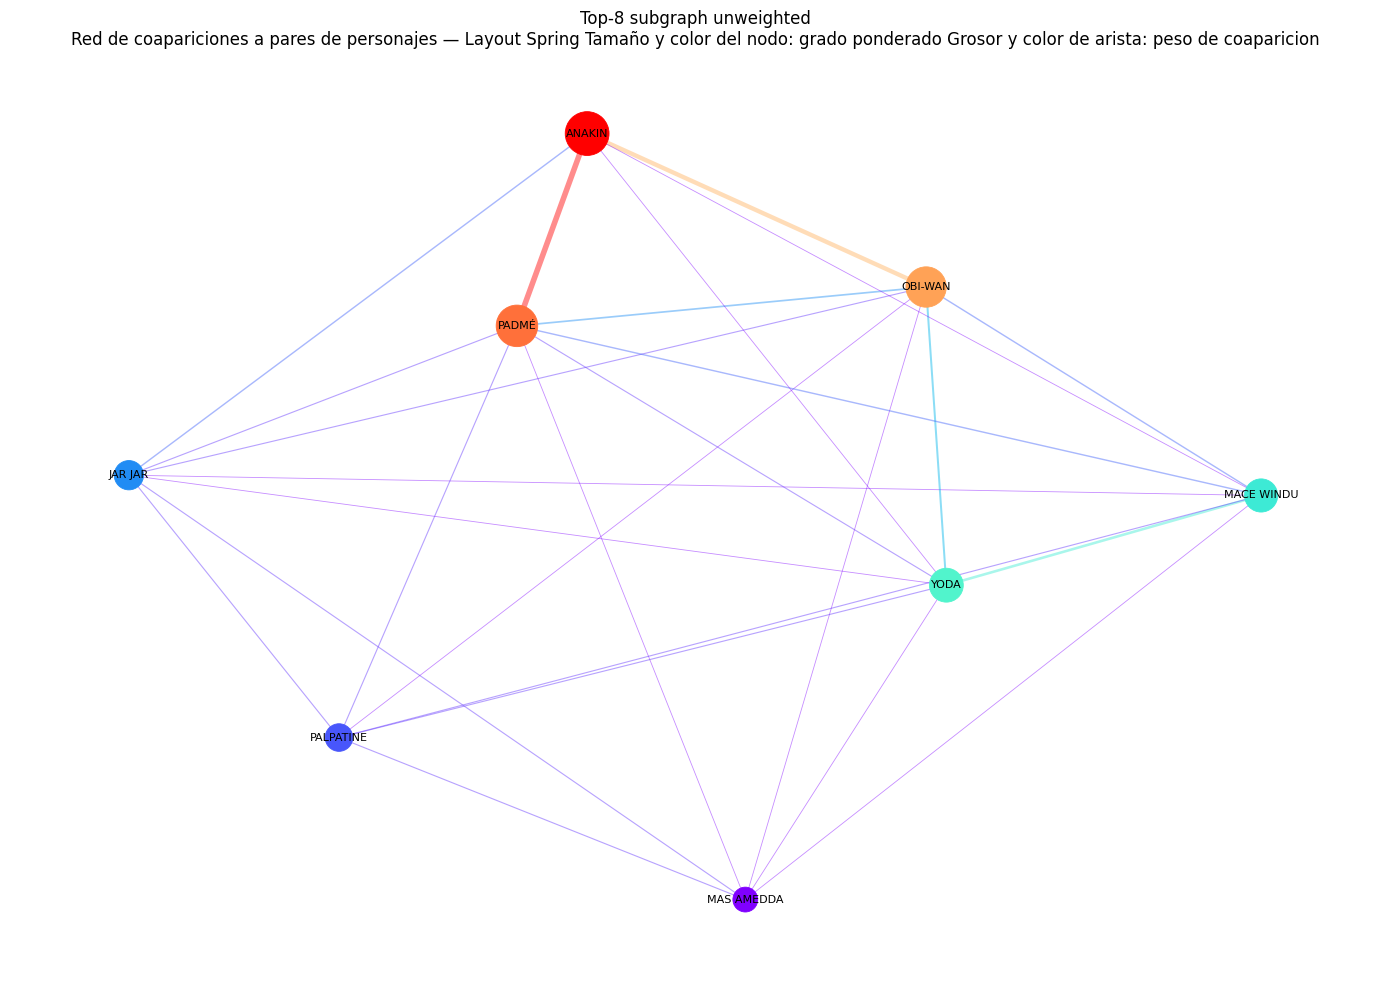

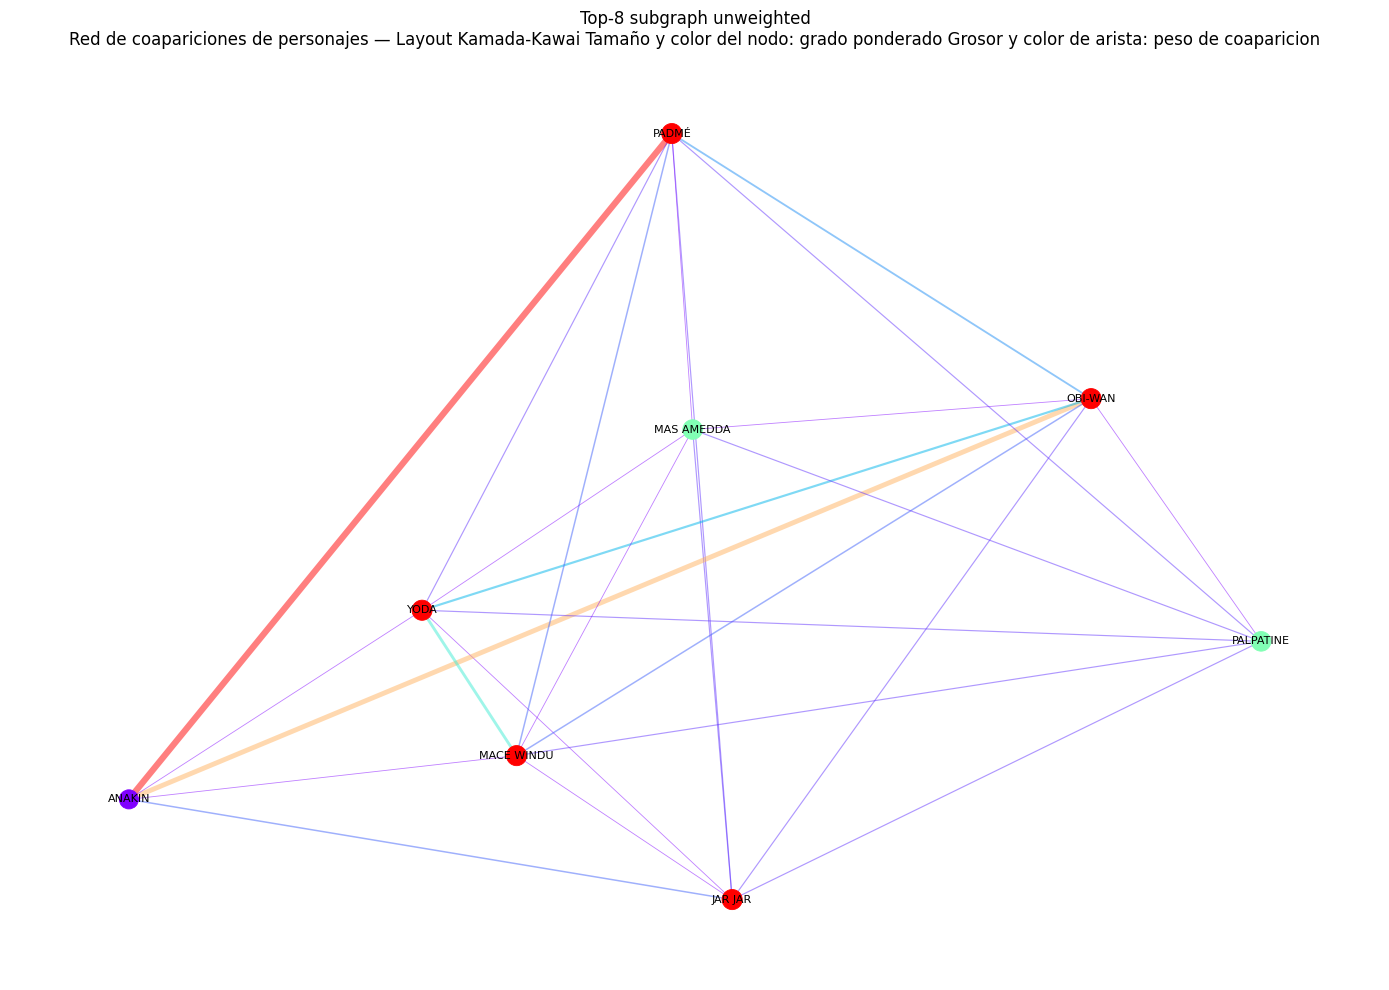

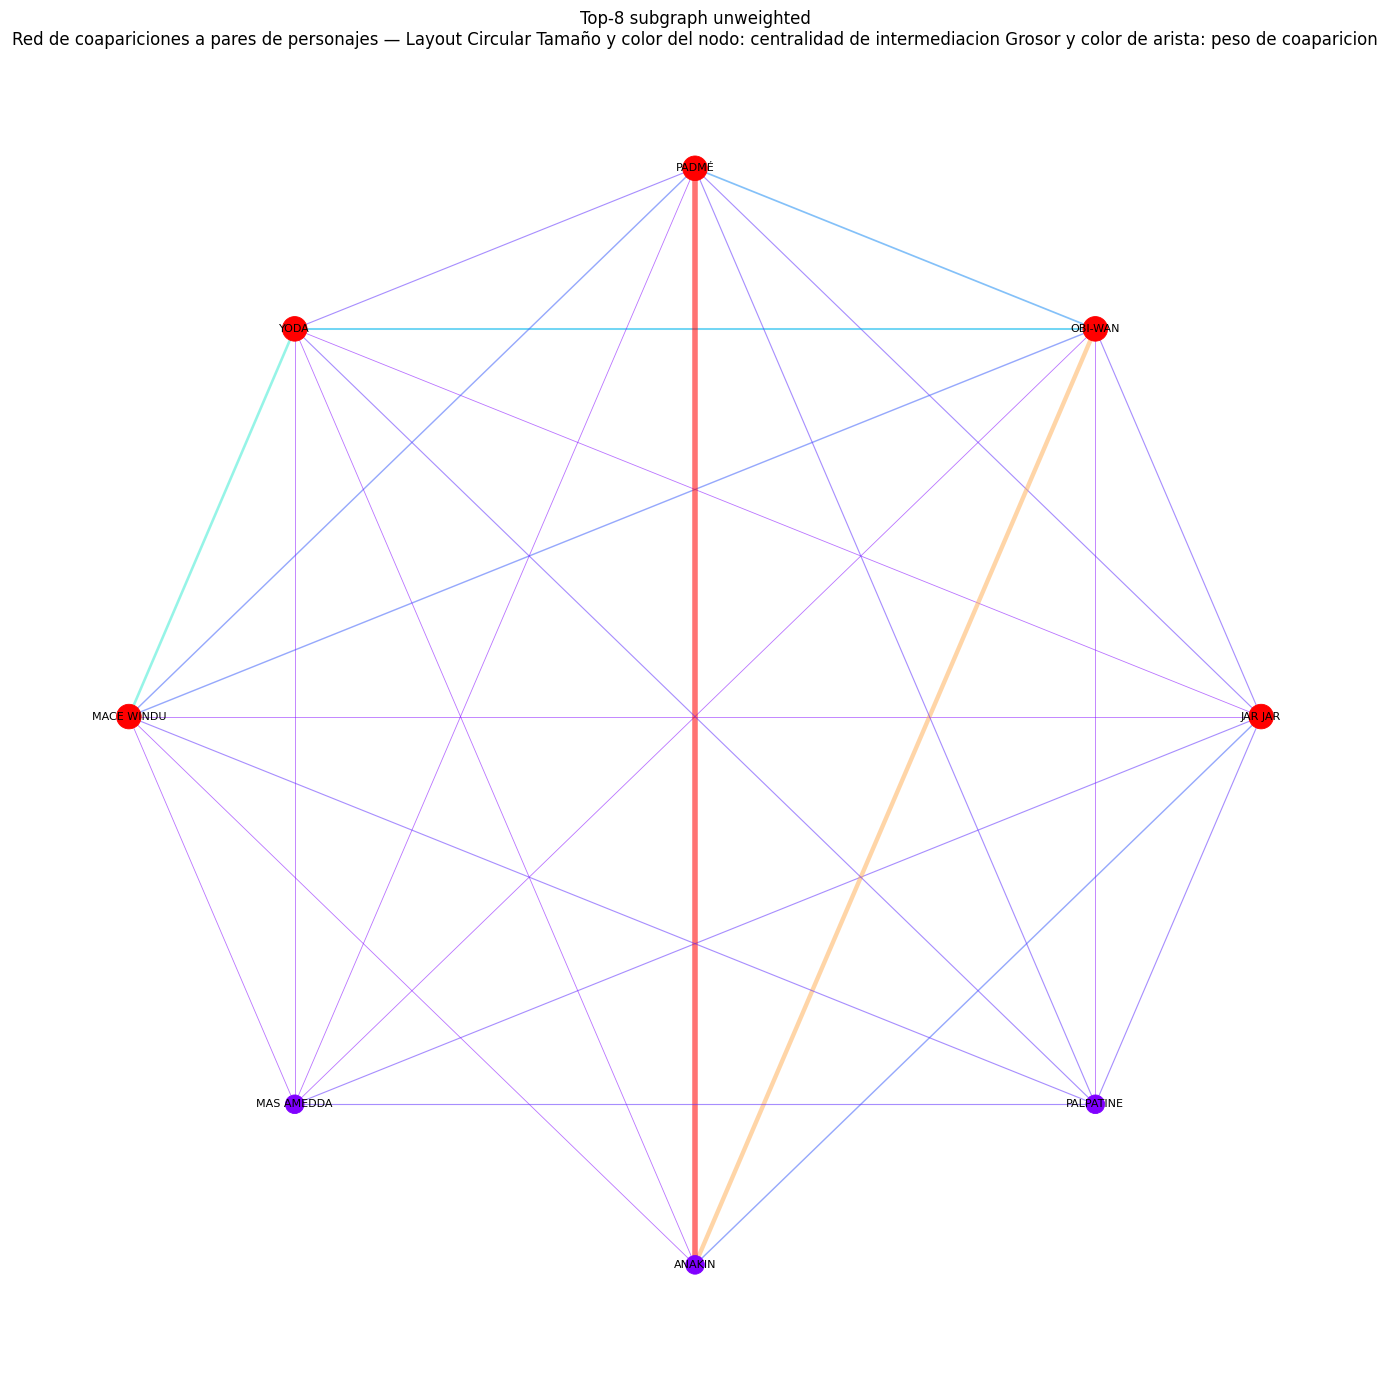

In [9]:
visualizacion1(G_top8, nombre_pelicula="Top-8 subgraph unweighted")
visualizacion2(G_top8, nombre_pelicula="Top-8 subgraph unweighted")
visualizacion3(G_top8, nombre_pelicula="Top-8 subgraph unweighted")

# Realiza una lista de grados: Identifica los nodos con mayor y con menor grado


In [10]:
deg_list = sorted(G.degree(weight="weight"), key=lambda x: x[1])

# menor y mayor grado (puede haber varios empatados)
min_deg = deg_list[0][1]
max_deg = deg_list[-1][1]

min_nodes = [(u, d) for u, d in deg_list if d == min_deg]
max_nodes = [(u, d) for u, d in deg_list if d == max_deg]

print(f"Grado minimo = {min_deg} | nodos: {len(min_nodes)}")
for u, d in min_nodes[:20]:
    print(G.nodes[u].get("label", str(u)), d)

print(f"\nGrado maximo = {max_deg} | nodos: {len(max_nodes)}")
for u, d in max_nodes[:20]:
    print(G.nodes[u].get("label", str(u)), d)

Grado minimo = 1.0 | nodos: 5
DARTH SIDIOUS 1.0
JOCASTA NU 1.0
PK-4 1.0
SHMI 1.0
WATTO 1.0

Grado maximo = 63.0 | nodos: 1
PADMÉ 63.0


In [11]:
k = 10
print("Ultimas 10:")
for u, d in deg_list[:k]:
    print(G.nodes[u].get("label", str(u)), d)

print("\nTop 10:")
for u, d in deg_list[-k:][::-1]:
    print(G.nodes[u].get("label", str(u)), d)

Ultimas 10:
DARTH SIDIOUS 1.0
JOCASTA NU 1.0
PK-4 1.0
SHMI 1.0
WATTO 1.0
CHILDREN 2.0
DEXTER JETTSTER 2.0
DOOKU 2.0
ELAN 2.0
HERMIONE BAGWA 2.0

Top 10:
PADMÉ 63.0
OBI-WAN 57.0
ANAKIN 56.0
YODA 27.0
MACE WINDU 25.0
PALPATINE 18.0
JAR JAR 17.0
MAS AMEDDA 13.0
COUNT DOOKU 13.0
SENATOR ASK AAK 11.0


# Encuentra el grado promedio


In [12]:
deg = dict(G.degree(weight="weight"))
avg_degree = float(np.mean(list(deg.values())))
print('Grado promedio ', avg_degree)

Grado promedio  9.872340425531915


En promedio, cada personaje tiene 9 coapariciones agregadas por pares

# Encuentra la densidad: ¿consideras que la red es dispersa o densa?


In [13]:
nx.density(G)

0.13691026827012026

Es dispersa, tiene 14% de todas las conexiones posibles

# Encuentra la cantidad de componentes


In [14]:
components = list(nx.connected_components(G))
num_components = len(components)
print('Cantidad de componentes', num_components)

Cantidad de componentes 1


# Calcula la distancia entre algunos nodos, por ejemplo, entre los de mayor y menor grado.


In [15]:
char1 = 'JAR JAR'
char2 = 'DARTH SIDIOUS'

dist_max_min = nx.shortest_path_length(G, char1, char2)
path_max_min = nx.shortest_path(G, char1, char2)
print(dist_max_min, path_max_min)

3 ['JAR JAR', 'ANAKIN', 'COUNT DOOKU', 'DARTH SIDIOUS']


https://screenrant.com/star-wars-details-prove-darth-jar-jar-theory/


# Calcula el diámetro, en caso de que la red sea disconexa, calcular el diámetro de cada componente


In [16]:
diameters = {}
for i, comp in enumerate(components, start=1):
    H = G.subgraph(comp).copy()
    diameters[i] = nx.diameter(H)
diameters

{1: 3}

mmm...

# Calcula la conectividad por aristas y por nodos entre algunos pares de nodos (por ejemplo entre los de mayor y menor grado)

In [17]:
def pares_mayor_menor_grado(G: nx.Graph):
    deg = dict(G.degree(weight="weight"))
    u_max = max(deg, key=deg.get)
    u_min = min(deg, key=deg.get)
    return G, u_max, u_min, deg[u_max], deg[u_min]


def conectividades_entre_pares(G: nx.Graph, pares: list[tuple] | None = None):
    out = []
    for s, t in pares:
        k_node = nx.node_connectivity(G, s, t)
        k_edge = nx.edge_connectivity(G, s, t)
        out.append((s, t, k_node, k_edge))
    return out

H, u_max, u_min, dmax, dmin = pares_mayor_menor_grado(G)

res = conectividades_entre_pares(H, pares=[(u_max, u_min)])
(s, t, k_node, k_edge) = res[0]

print("Nodo mayor grado:", u_max, "| grado =", dmax)
print("Nodo menor grado:", u_min, "| grado =", dmin)
print(f"\nConectividad por nodos ({s},{t}) =", k_node)
print(f"Conectividad por aristas ({s},{t}) =", k_edge)


Nodo mayor grado: PADMÉ | grado = 63.0
Nodo menor grado: DARTH SIDIOUS | grado = 1.0

Conectividad por nodos (PADMÉ,DARTH SIDIOUS) = 1
Conectividad por aristas (PADMÉ,DARTH SIDIOUS) = 1


# Encuentra un conjunto mínimo de nodos de corte.


In [18]:
cut = nx.minimum_node_cut(G)
cut

{'COUNT DOOKU'}

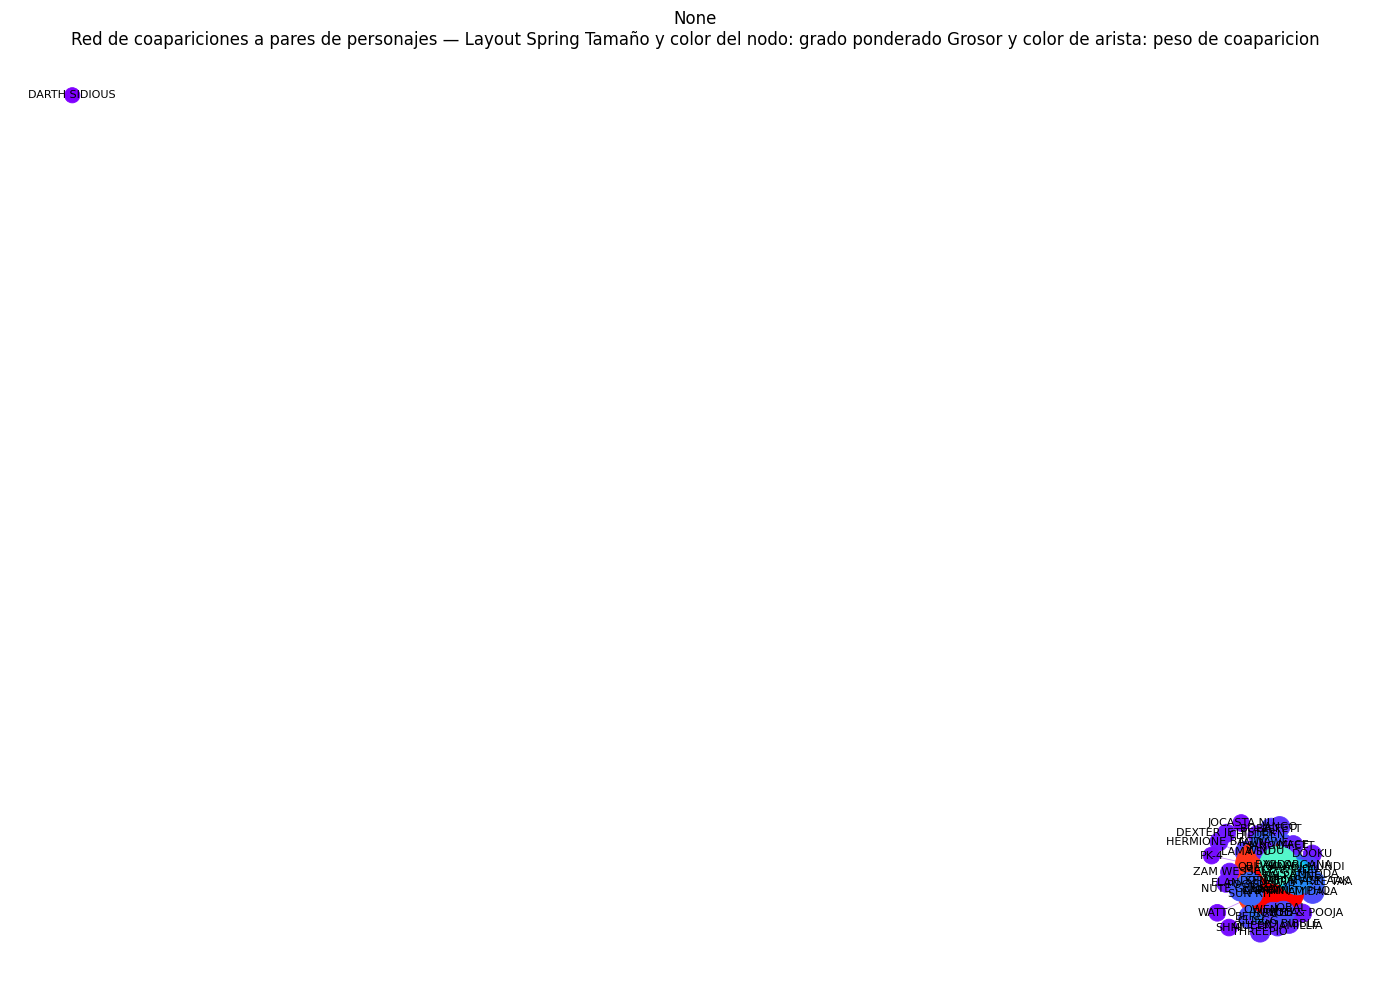

In [19]:
H = G.subgraph(set(G.nodes()) - set(cut))
visualizacion1(H)

Conde Dooku era el unico conectado a Darth Sidious

# Calcula su matriz Laplaciana (omite direcciones si es necesario), sus eigenvalores y sus eigenvectores (el espectro). Verifica que la multiplicidad del eigenvalor cero es la misma que la cantidad de componentes


In [20]:
L1 = nx.laplacian_matrix(G)
pd.DataFrame(L1.toarray())

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,6.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,56.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-1.0
2,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
3,0.0,-1.0,0.0,6.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,-1.0,-1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
7,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,-1.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-2.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


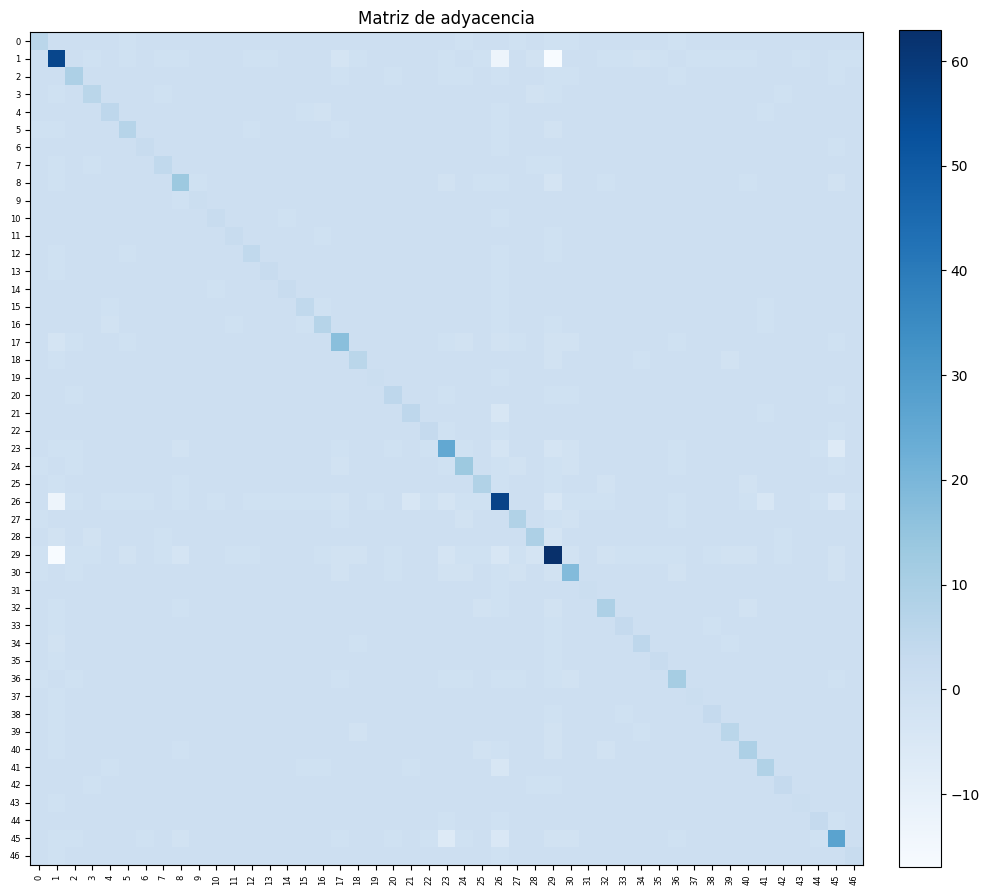

In [21]:
plot_adjacency_matrix(pd.DataFrame(L1.toarray()))

In [22]:
eigenvals, eigenvectores = np.linalg.eig(L1.toarray())
eigenvals = np.sort(np.array([0.0 if x < 0 else float(x) for x in eigenvals]))
eigenvals

array([ 0.        ,  0.91141776,  0.94466556,  1.        ,  1.        ,
        1.        ,  1.06389074,  1.53102865,  1.84132177,  1.9586292 ,
        2.        ,  2.        ,  2.02035728,  2.1789049 ,  2.30488963,
        2.74859572,  3.        ,  3.        ,  3.09323704,  3.55715204,
        3.70299867,  4.        ,  4.01698013,  4.49422994,  4.7072972 ,
        5.26309828,  5.98105414,  6.25379642,  6.71437815,  7.60873144,
        8.        ,  8.20548071,  8.69308674,  8.832263  ,  9.89487148,
       10.33965475, 11.        , 11.21452634, 12.24788013, 13.44778228,
       16.86208196, 19.25197148, 21.70511255, 32.94010886, 38.88771124,
       63.75653466, 78.82427917])

Hay un eigenvector = 0. Hay una componente

In [23]:
eigenvectores

array([[-8.31351866e-03,  9.11100382e-03, -1.07855317e-02, ...,
         1.34180868e-17,  2.77125065e-17,  4.43242270e-17],
       [-6.68900887e-01, -1.81613691e-01,  6.83443368e-01, ...,
        -3.78127744e-17, -9.13868146e-17,  9.21843276e-17],
       [-1.22381053e-02, -3.61515709e-03, -1.24643809e-02, ...,
         7.94208274e-17,  1.02606197e-16, -4.38077324e-18],
       ...,
       [-3.04707205e-03, -1.20065646e-02, -3.07004179e-03, ...,
         1.81394388e-16, -2.58189391e-16, -1.44522234e-17],
       [-3.47005637e-02, -7.55355398e-02, -2.29347693e-01, ...,
        -2.10173929e-17,  5.47566883e-17, -4.80268931e-17],
       [ 4.79386046e-03, -1.01449757e-02, -3.04781194e-02, ...,
        -1.75445523e-17,  4.43656537e-17,  2.00988452e-16]],
      shape=(47, 47))